In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [8]:
# Load preprocessed data
df = pd.read_csv('preprocessed_data.csv')
X = df.drop('Exited', axis=1)
y = df['Exited']

In [9]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Base model training
rf_base = RandomForestClassifier(random_state=42)
rf_base.fit(X_train, y_train)
base_predictions = rf_base.predict(X_test)

print("Base Model Performance:")
print(classification_report(y_test, base_predictions))

Base Model Performance:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1607
           1       0.75      0.47      0.57       393

    accuracy                           0.86      2000
   macro avg       0.81      0.71      0.75      2000
weighted avg       0.85      0.86      0.85      2000



In [10]:
# Rest of the code remains the same as before
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("\nBest parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)


Best parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation score: 0.8583281908084043


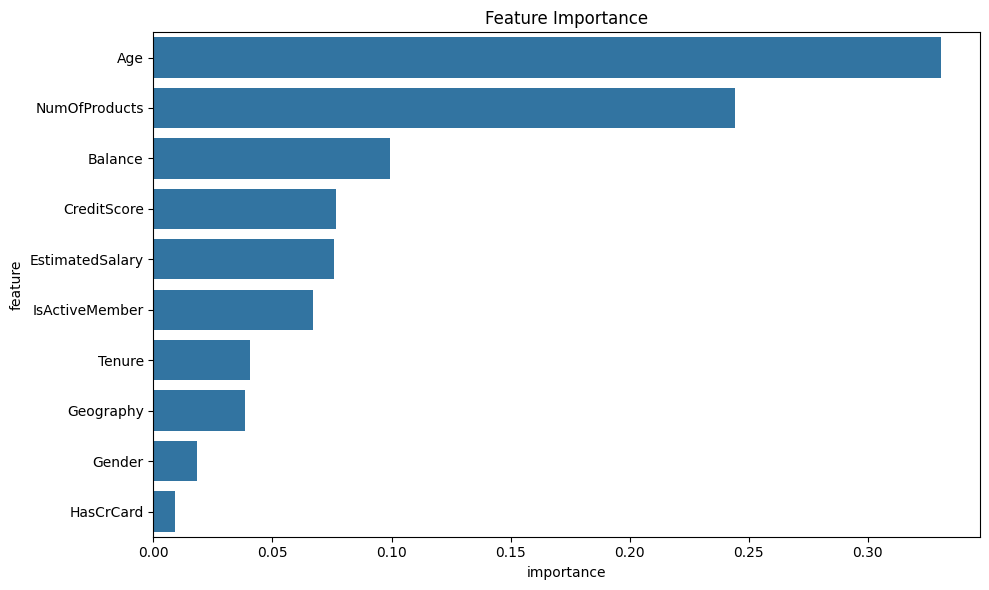

In [11]:
# Train final model with best parameters
best_rf = grid_search.best_estimator_
final_predictions = best_rf.predict(X_test)

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

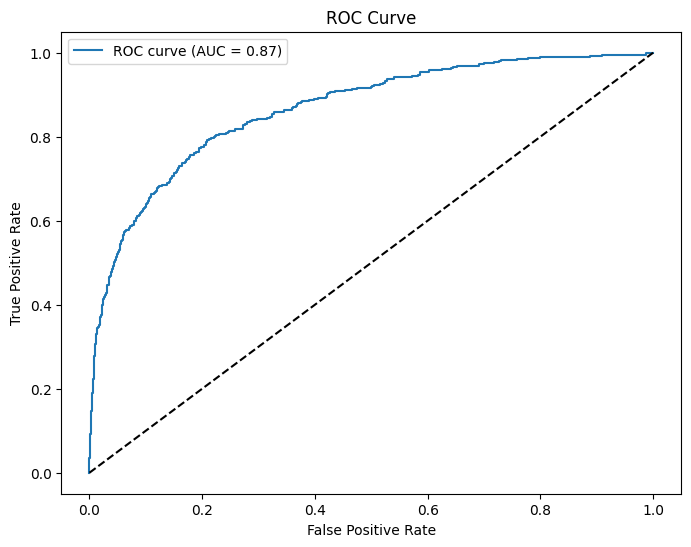

In [12]:
# ROC Curve
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

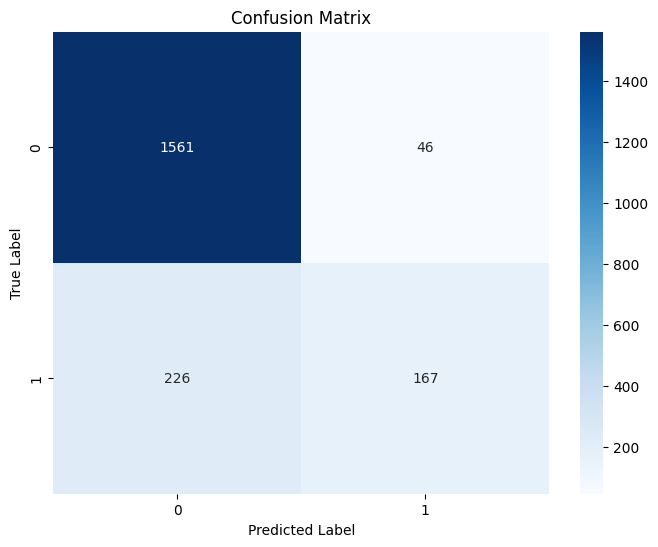

In [13]:
# Confusion Matrix
cm = confusion_matrix(y_test, final_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [14]:
# Save model
model_data = {
    'model': best_rf,
    'feature_importance': feature_importance,
    'best_params': grid_search.best_params_
}
joblib.dump(model_data, 'final_model.joblib')


['final_model.joblib']

In [16]:
# Prediction function for new data
def predict_churn(data):
    model_data = joblib.load('final_model.joblib')
    model = model_data['model']
    return model.predict(data)



[0 0 0 ... 1 0 0]
